# Running cellpose in colab with a GPU


## installation

Check CUDA version and GPU first

In [ ]:
!nvcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
Tue Nov 16 09:39:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |            

Install cellpose -- by default the torch GPU version is installed in COLAB notebook.

In [ ]:
!pip install cellpose 

import libraries and check GPU (the first time you import cellpose the models will download).

In [ ]:
import numpy as np
import time, os, sys
from urllib.parse import urlparse
import skimage.io
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

from urllib.parse import urlparse
from cellpose import models

use_GPU = models.use_gpu()
print('>>> GPU activated? %d'%use_GPU)


creating new log file
2021-11-16 09:40:33,503 [INFO] WRITING LOG OUTPUT TO /root/.cellpose/run.log


AttributeError: ignored

Download cell images

In [ ]:
import zipfile
from google_drive_downloader import GoogleDriveDownloader as gdd
import glob
import cv2
from cellpose import models

In [ ]:
gdd.download_file_from_google_drive(file_id='1HJMWxmIjXW32hles0t0WoMBYlYOrYRpe',
                                    dest_path = '/content/prim.zip', overwrite=True)

with zipfile.ZipFile('/content/prim.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [ ]:
def normalize(img):
  # THE WAY THE CODE WORKS NORMALIZING ON COLAB IS IMPOSSIBLE BC IT USES TOO MUCH RAM
  return 255*img/np.amax(img)

def create_cells():
    # creat list handles
    all_cells = []
    group_names = []
    all_class_names = []

    # go through all the types of groups
    for filename in glob.glob('/content/HEP annot/*'): 
        # save their names
        group_names.append(filename[len("/content/HEP annot/"):])
        names = []
        class_cells = []
        class_names = []
        # go through all the classes of cells within a group
        for cell_class in glob.glob(filename+'/*'):
            # save their names
            class_names.append(cell_class[len(filename)+1:])

            # go through all the images of cells within a class
            images = []
            for cell in glob.glob(cell_class+'/*'):
                #print(cell)
                images.append(cv2.imread(cell))
            # save images to class 
            class_cells.append(images)
        # save all data  in final list
        all_cells.append(class_cells)
        all_class_names.append(class_names)
    return  all_cells, group_names, all_class_names

def apply_mask (img, mask):
  cells = []
  for i in range(1, np.amax(mask)+1):
    x, y = np.where(mask==i)
    cells.append(img[np.amin(x):np.amax(x)+1, np.amin(y):np.amax(y)+1])
  return cells


In [ ]:
all_cells, group_names, all_class_names = create_cells()

Now we normalize the cell images

I'll do this later, have to optimize bc not enough space



In [ ]:
"""for i_group in range(np.shape(all_cells)[0]):
  for i_class in range(np.shape(all_cells[i_group])[0]):
    for i in range(np.shape(all_cells[i_group][i_class])[0]):
      aux = 255 / np.amax(all_cells[i_group][i_class][i])
      all_cells[i_group][i_class][i] = all_cells[i_group][i_class][i]"""



## run cellpose on 2D sample images

In [ ]:
# RUN CELLPOSE
# TO RUN FOR ALL CELLS UN COMMENT THE THREE LINES BELOW
#for i_group in range(np.shape(all_cells)[0]):
  #for i_class in range(np.shape(all_cells[i_group])[0]):

#imgs_2D = all_cells[i_group][i_class] 
imgs_2D = all_cells[0][0] #COMMENT THIS

# DEFINE CELLPOSE MODEL
# model_type='cyto' or model_type='nuclei'
model = models.Cellpose(gpu=use_GPU, model_type='cyto')

# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
# channels = [0,0]
# IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
# channels = [0,0] # IF YOU HAVE GRAYSCALE
# channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
# channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus

# or if you have different types of channels in each image
channels = [2, 2]
# channels = [1,1]

# if diameter is set to None, the size of the cells is estimated on a per image basis
# you can set the average cell `diameter` in pixels yourself (recommended) 
# diameter can be a list or a single number for all images

masks, flows, styles, diams = model.eval(imgs_2D, diameter=None, flow_threshold=None, channels=channels)

# BATCHES ARE DETERMINED BY CLASS

cells = []
for i in range(np.shape(masks)[0]):
  #cells.append(apply_mask(all_cells[i_group][i_class][i], masks[i])) #UNCOMMENT
  cells.append(apply_mask(all_cells[0][0][i], masks[i])) #COMMENT
# This code will return a cell array. This array is of length equal to the number of images
# It contains sub-arrays containing every isolated cell

    #TO IMPLEMENT
    # PUT CELL IN FRONT OF UNIFORM BLACK SQUARE
      # POSSIBLE ISSUES: OVERLAP BETWEEN CELLS
      # CELLS OF VARYING SIZES
    #SEND TO DRIVE, MUST STILL DECIDE ON HOW TO ORGANIZE UPLOADS


2021-10-20 14:56:57,421 [INFO] ** TORCH CUDA version installed and working. **
2021-10-20 14:56:57,422 [INFO] >>>> using GPU
2021-10-20 14:56:57,581 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-10-20 14:56:57,586 [INFO] 0%|          | 0/36 [00:00<?, ?it/s]


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


2021-10-20 15:00:08,773 [INFO] 100%|##########| 36/36 [03:11<00:00,  5.31s/it]
2021-10-20 15:00:08,776 [INFO] estimated cell diameter(s) in 191.20 sec
2021-10-20 15:00:08,779 [INFO] >>> diameter(s) = 
2021-10-20 15:00:08,782 [INFO] [69.22, 61.90, 65.67, 61.68, 72.31, 76.97, 67.85, 71.99, 73.27, 67.61, 62.58, 60.45, 63.19, 78.03, 61.64, 67.43, 62.77, 68.80, 65.06, 65.09, 65.61, 64.62, 63.58, 75.35, 64.48, 63.44, 64.20, 63.29, 75.90, 72.70, 68.26, 69.98, 69.75, 70.42, 64.68, 66.42, ]
2021-10-20 15:00:08,784 [INFO] ~~~ FINDING MASKS ~~~
2021-10-20 15:00:08,787 [INFO] 0%|          | 0/36 [00:00<?, ?it/s]


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3982: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


2021-10-20 15:01:34,482 [INFO] 100%|##########| 36/36 [01:25<00:00,  2.38s/it]
2021-10-20 15:01:34,484 [INFO] >>>> TOTAL TIME 276.90 sec


I ran this just to test on the first class, with 36 images in total. The results were successfull as following.

In [ ]:
print("The amount of cells obtained for GROUP 1 and CLASS 1 were: ")
y = []
x = []
for i in range(len(cells)):
  print(f'For the {i+1}th image: {len(cells[i])}')
  x.append(max([np.shape(a)[0] for a in cells[i]]))
  y.append(max([np.shape(a)[1] for a in cells[i]]))
print(max(x), max(y))
#print(min(x), min(y))

The amount of cells obtained for GROUP 1 and CLASS 1 were: 
For the 1th image: 77
For the 2th image: 110
For the 3th image: 120
For the 4th image: 85
For the 5th image: 95
For the 6th image: 84
For the 7th image: 66
For the 8th image: 73
For the 9th image: 85
For the 10th image: 75
For the 11th image: 113
For the 12th image: 100
For the 13th image: 91
For the 14th image: 77
For the 15th image: 99
For the 16th image: 72
For the 17th image: 76
For the 18th image: 84
For the 19th image: 123
For the 20th image: 73
For the 21th image: 97
For the 22th image: 88
For the 23th image: 93
For the 24th image: 67
For the 25th image: 90
For the 26th image: 116
For the 27th image: 109
For the 28th image: 101
For the 29th image: 56
For the 30th image: 82
For the 31th image: 82
For the 32th image: 60
For the 33th image: 73
For the 34th image: 82
For the 35th image: 86
For the 36th image: 64
287 247


In [ ]:
cells[i]

In [ ]:
"""from cellpose import plot
fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, imgs_2D, masks, flows, channels=channels)
plt.tight_layout
plt.show()"""


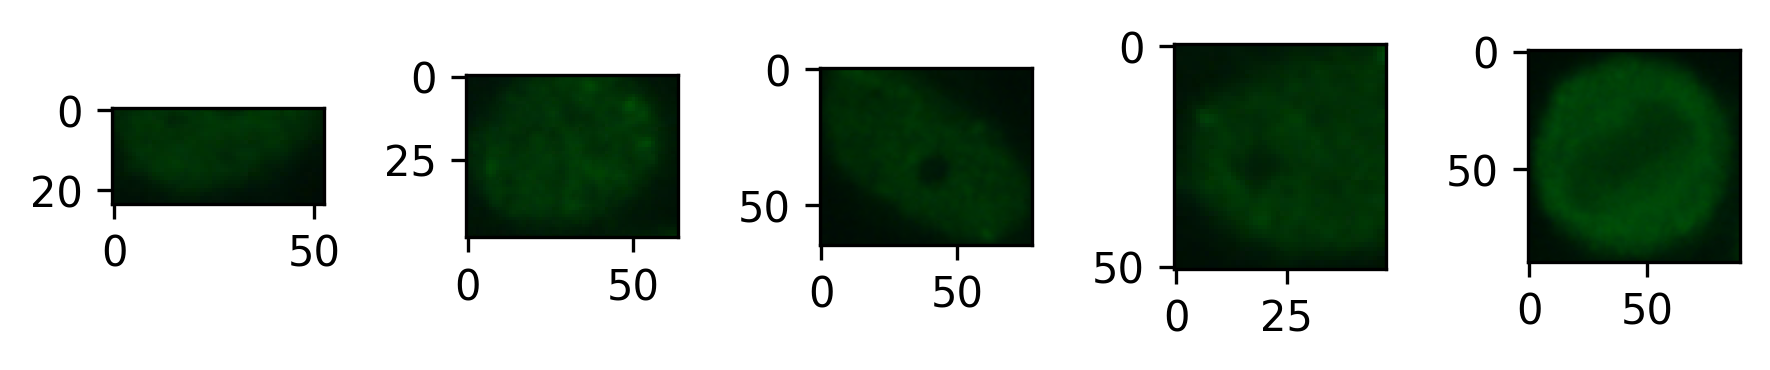

In [ ]:
plt.subplots(1, 5)
for i in range(1, 6):
  plt.subplot(1, 5, i)
  plt.imshow(cells[0][i-1])
plt.tight_layout()